
### 🚗 **Proactive Vehicle Health Monitoring Project**

Welcome to the Proactive Vehicle Health Monitoring Project! In this notebook, we will cover the entire workflow for building a predictive maintenance model for vehicle health. This includes data loading, preprocessing, feature engineering, model training, and evaluation.

---



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_style("whitegrid")

DATA_PATH = "/kaggle/input/nasa-cmaps/CMaps" # Or your Kaggle input path like "/kaggle/input/nasa-cmaps/"

In [2]:
columns = ['unit_number', 'cycle']
columns += ['setting{}'.format(i) for i in range(1, 4)]
columns += ['sensor{}'.format(i) for i in range(1, 22)]

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_FD001.txt'), sep='\s+', header=None, names=columns)

test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_FD001.txt'), sep='\s+', header=None, names=columns)

rul_df = pd.read_csv(os.path.join(DATA_PATH, 'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

In [3]:
print("--- Training Data ---")
print(train_df.head())
print(f"\nShape of training data: {train_df.shape}")
print(f"Number of unique engines in training: {train_df['unit_number'].nunique()}")


--- Training Data ---
   unit_number  cycle  setting1  setting2  setting3  sensor1  sensor2  \
0            1      1   -0.0007   -0.0004     100.0   518.67   641.82   
1            1      2    0.0019   -0.0003     100.0   518.67   642.15   
2            1      3   -0.0043    0.0003     100.0   518.67   642.35   
3            1      4    0.0007    0.0000     100.0   518.67   642.35   
4            1      5   -0.0019   -0.0002     100.0   518.67   642.37   

   sensor3  sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  \
0  1589.70  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195   
1  1591.82  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318   
2  1587.99  1404.20    14.62  ...    522.42   2388.03   8133.23    8.4178   
3  1582.79  1401.87    14.62  ...    522.86   2388.08   8133.83    8.3682   
4  1582.85  1406.22    14.62  ...    522.19   2388.04   8133.80    8.4294   

   sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  
0      0.03 

In [4]:
print("\n--- Test Data ---")
print(test_df.head())
print(f"\nShape of test data: {test_df.shape}")
print(f"Number of unique engines in test: {test_df['unit_number'].nunique()}")


--- Test Data ---
   unit_number  cycle  setting1  setting2  setting3  sensor1  sensor2  \
0            1      1    0.0023    0.0003     100.0   518.67   643.02   
1            1      2   -0.0027   -0.0003     100.0   518.67   641.71   
2            1      3    0.0003    0.0001     100.0   518.67   642.46   
3            1      4    0.0042    0.0000     100.0   518.67   642.44   
4            1      5    0.0014    0.0000     100.0   518.67   642.51   

   sensor3  sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  \
0  1585.29  1398.21    14.62  ...    521.72   2388.03   8125.55    8.4052   
1  1588.45  1395.42    14.62  ...    522.16   2388.06   8139.62    8.3803   
2  1586.94  1401.34    14.62  ...    521.97   2388.03   8130.10    8.4441   
3  1584.12  1406.42    14.62  ...    521.38   2388.05   8132.90    8.3917   
4  1587.19  1401.92    14.62  ...    522.15   2388.03   8129.54    8.4031   

   sensor16  sensor17  sensor18  sensor19  sensor20  sensor21  
0      0.03    

In [5]:
print("\n--- RUL Data for Test Set ---")
print(rul_df.head())
print(f"\nShape of RUL data: {rul_df.shape}")


--- RUL Data for Test Set ---
   RUL
0  112
1   98
2   69
3   82
4   91

Shape of RUL data: (100, 1)


In [6]:
print("\n--- Training Data Description ---")
print(train_df.describe().transpose())


--- Training Data Description ---
               count         mean           std        min        25%  \
unit_number  20631.0    51.506568  2.922763e+01     1.0000    26.0000   
cycle        20631.0   108.807862  6.888099e+01     1.0000    52.0000   
setting1     20631.0    -0.000009  2.187313e-03    -0.0087    -0.0015   
setting2     20631.0     0.000002  2.930621e-04    -0.0006    -0.0002   
setting3     20631.0   100.000000  0.000000e+00   100.0000   100.0000   
sensor1      20631.0   518.670000  6.537152e-11   518.6700   518.6700   
sensor2      20631.0   642.680934  5.000533e-01   641.2100   642.3250   
sensor3      20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600   
sensor4      20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600   
sensor5      20631.0    14.620000  3.394700e-12    14.6200    14.6200   
sensor6      20631.0    21.609803  1.388985e-03    21.6000    21.6100   
sensor7      20631.0   553.367711  8.850923e-01   549.8500   552.8100   
sensor8      206

In [7]:
print("\n--- Missing Values in Training Data ---")
print(train_df.isnull().sum().any()) # Should be False


--- Missing Values in Training Data ---
False


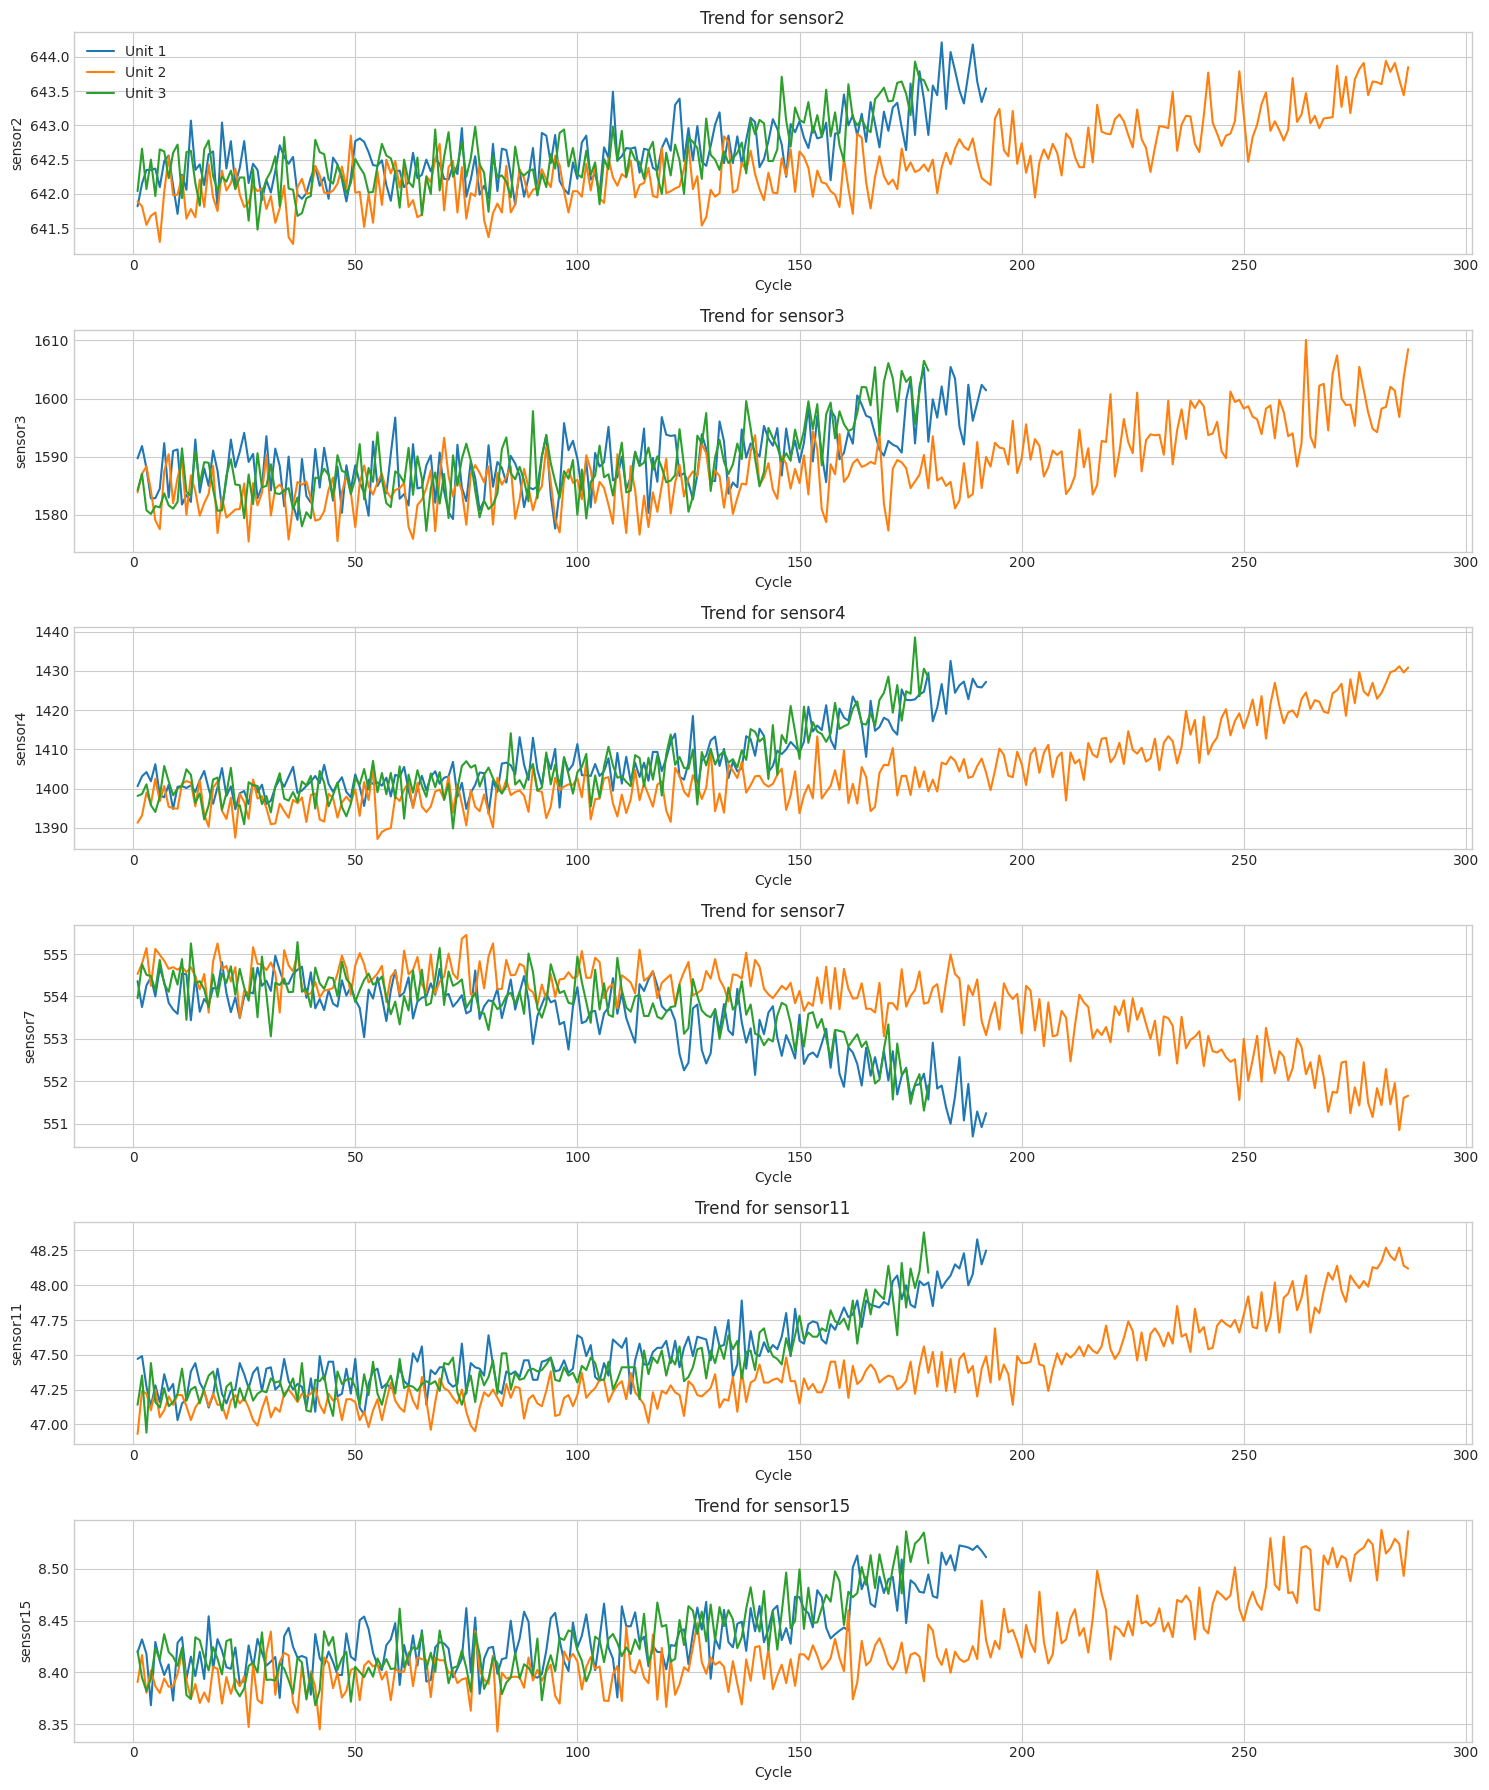

In [9]:
def plot_sensor_trends(df, unit_numbers, sensors_to_plot):
    plt.figure(figsize=(15, len(sensors_to_plot) * 3))
    for i, sensor in enumerate(sensors_to_plot):
        plt.subplot(len(sensors_to_plot), 1, i + 1)
        for unit in unit_numbers:
            engine_data = df[df['unit_number'] == unit]
            plt.plot(engine_data['cycle'], engine_data[sensor], label=f'Unit {unit}')
        plt.title(f'Trend for {sensor}')
        plt.xlabel('Cycle')
        plt.ylabel(sensor)
        if i == 0: # Add legend only to the first plot to avoid clutter
            plt.legend()
    plt.tight_layout()
    plt.show()

sensors_with_trends = ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor11', 'sensor15']
plot_sensor_trends(train_df, unit_numbers=[1, 2, 3], sensors_to_plot=sensors_with_trends)

# Step 2: Data Preprocessing

Remove Constant/Irrelevant Features: 
Identify sensors or settings that don't change much or at all.

Feature Scaling: 
Scale numerical features.

In [13]:
print("\n--- Unique values per column (Training Data) ---")

desc_df = train_df.describe()
std_devs = desc_df.loc['std']
constant_cols = std_devs[std_devs == 0].index.tolist()
print(f"\nColumns with zero standard deviation (constant): {constant_cols}")


--- Unique values per column (Training Data) ---

Columns with zero standard deviation (constant): ['setting3', 'sensor18', 'sensor19']


In [14]:

train_df_processed = train_df.copy()
test_df_processed = test_df.copy()

In [15]:
cols_to_drop = constant_cols # Example: ['setting3', 'sensor1', 'sensor5', 'sensor10', 'sensor16', 'sensor18', 'sensor19']
cols_to_drop_FD001 = ['setting3', 'sensor18', 'sensor19']

In [16]:
cols_to_drop_FD001_actual = [col for col in cols_to_drop_FD001 if col in train_df_processed.columns]


train_df_processed = train_df_processed.drop(columns=cols_to_drop_FD001_actual)
test_df_processed = test_df_processed.drop(columns=cols_to_drop_FD001_actual)

print(f"\nDropped columns: {cols_to_drop_FD001_actual}")
print(f"Training data shape after dropping: {train_df_processed.shape}")
print(f"Test data shape after dropping: {test_df_processed.shape}")


Dropped columns: ['setting3', 'sensor18', 'sensor19']
Training data shape after dropping: (20631, 23)
Test data shape after dropping: (13096, 23)


In [17]:
features_to_scale = [col for col in train_df_processed.columns if col not in ['unit_number', 'cycle']]

scaler = StandardScaler()

train_df_processed[features_to_scale] = scaler.fit_transform(train_df_processed[features_to_scale])

test_df_processed[features_to_scale] = scaler.transform(test_df_processed[features_to_scale])

print("\n--- Scaled Training Data (First 5 rows) ---")
print(train_df_processed.head())


--- Scaled Training Data (First 5 rows) ---
   unit_number  cycle  setting1  setting2  sensor1   sensor2   sensor3  \
0            1      1 -0.315980 -1.372953      0.0 -1.721725 -0.134255   
1            1      2  0.872722 -1.031720      0.0 -1.061780  0.211528   
2            1      3 -1.961874  1.015677      0.0 -0.661813 -0.413166   
3            1      4  0.324090 -0.008022      0.0 -0.661813 -1.261314   
4            1      5 -0.864611 -0.690488      0.0 -0.621816 -1.251528   

    sensor4  sensor5   sensor6  ...  sensor10  sensor11  sensor12  sensor13  \
0 -0.925936      0.0  0.141683  ...       0.0 -0.266467  0.334262 -1.058890   
1 -0.643726      0.0  0.141683  ...       0.0 -0.191583  1.174899 -0.363646   
2 -0.525953      0.0  0.141683  ...       0.0 -1.015303  1.364721 -0.919841   
3 -0.784831      0.0  0.141683  ...       0.0 -1.539489  1.961302 -0.224597   
4 -0.301518      0.0  0.141683  ...       0.0 -0.977861  1.052871 -0.780793   

   sensor14  sensor15      sensor16

# Step 3: Target Variable Engineering (Calculating RUL)
For the training data, we need to calculate the RUL for each cycle.

A common practice for C-MAPSS is to cap the RUL. This means we assume that predicting failures too 

far in advance is less useful and harder, so we set a maximum RUL value (e.g., 125 or 150 cycles).

In [18]:
max_cycles_df = train_df_processed.groupby('unit_number')['cycle'].max().reset_index()
max_cycles_df.columns = ['unit_number', 'max_cycle']

train_df_processed = pd.merge(train_df_processed, max_cycles_df, on='unit_number', how='left')

train_df_processed['RUL'] = train_df_processed['max_cycle'] - train_df_processed['cycle']

train_df_processed = train_df_processed.drop(columns=['max_cycle'])

print("\n--- Training Data with RUL (First 5 rows for unit 1) ---")
print(train_df_processed[train_df_processed['unit_number']==1].head())
print("\n--- Training Data with RUL (Last 5 rows for unit 1) ---")
print(train_df_processed[train_df_processed['unit_number']==1].tail())


--- Training Data with RUL (First 5 rows for unit 1) ---
   unit_number  cycle  setting1  setting2  sensor1   sensor2   sensor3  \
0            1      1 -0.315980 -1.372953      0.0 -1.721725 -0.134255   
1            1      2  0.872722 -1.031720      0.0 -1.061780  0.211528   
2            1      3 -1.961874  1.015677      0.0 -0.661813 -0.413166   
3            1      4  0.324090 -0.008022      0.0 -0.661813 -1.261314   
4            1      5 -0.864611 -0.690488      0.0 -0.621816 -1.251528   

    sensor4  sensor5   sensor6  ...  sensor11  sensor12  sensor13  sensor14  \
0 -0.925936      0.0  0.141683  ... -0.266467  0.334262 -1.058890 -0.269071   
1 -0.643726      0.0  0.141683  ... -0.191583  1.174899 -0.363646 -0.642845   
2 -0.525953      0.0  0.141683  ... -1.015303  1.364721 -0.919841 -0.551629   
3 -0.784831      0.0  0.141683  ... -1.539489  1.961302 -0.224597 -0.520176   
4 -0.301518      0.0  0.141683  ... -0.977861  1.052871 -0.780793 -0.521748   

   sensor15      senso

In [19]:
RUL_CAP = 125 # Common choice, can be tuned
train_df_processed['RUL'] = train_df_processed['RUL'].clip(upper=RUL_CAP)

print(f"\n--- Training Data with Capped RUL (Max RUL: {train_df_processed['RUL'].max()}) ---")
print(train_df_processed[train_df_processed['unit_number']==1].head())




--- Training Data with Capped RUL (Max RUL: 125) ---
   unit_number  cycle  setting1  setting2  sensor1   sensor2   sensor3  \
0            1      1 -0.315980 -1.372953      0.0 -1.721725 -0.134255   
1            1      2  0.872722 -1.031720      0.0 -1.061780  0.211528   
2            1      3 -1.961874  1.015677      0.0 -0.661813 -0.413166   
3            1      4  0.324090 -0.008022      0.0 -0.661813 -1.261314   
4            1      5 -0.864611 -0.690488      0.0 -0.621816 -1.251528   

    sensor4  sensor5   sensor6  ...  sensor11  sensor12  sensor13  sensor14  \
0 -0.925936      0.0  0.141683  ... -0.266467  0.334262 -1.058890 -0.269071   
1 -0.643726      0.0  0.141683  ... -0.191583  1.174899 -0.363646 -0.642845   
2 -0.525953      0.0  0.141683  ... -1.015303  1.364721 -0.919841 -0.551629   
3 -0.784831      0.0  0.141683  ... -1.539489  1.961302 -0.224597 -0.520176   
4 -0.301518      0.0  0.141683  ... -0.977861  1.052871 -0.780793 -0.521748   

   sensor15      sensor16 

# Step 4: Feature Engineering (Rolling Window Features)

To capture the temporal dynamics and trends in sensor data, we'll create rolling window features 
(e.g., mean, std dev of sensors over the last N cycles).

In [20]:

sensor_cols = [col for col in features_to_scale if 'setting' not in col] # features_to_scale now only contains settings and sensors

window_size = 5 # Number of past cycles to consider for rolling features (hyperparameter)

train_FE = train_df_processed.copy()
test_FE = test_df_processed.copy()

def add_rolling_features(df, sensor_cols_list, window):
    df_out = df.copy()
    for col in sensor_cols_list:
        df_out[f'{col}_rolling_mean_w{window}'] = df_out.groupby('unit_number')[col].transform(
            lambda x: x.rolling(window, min_periods=1).mean() # min_periods=1 fills initial NaNs with expanding window
        )
        df_out[f'{col}_rolling_std_w{window}'] = df_out.groupby('unit_number')[col].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
    df_out = df_out.fillna(0) # A simple way, could also use bfill then ffill
    return df_out

train_FE = add_rolling_features(train_FE, sensor_cols, window_size)
test_FE = add_rolling_features(test_FE, sensor_cols, window_size)

print("\n--- Training Data with Rolling Features (Example) ---")
print(train_FE[train_FE['unit_number']==1][['cycle', 'sensor2', f'sensor2_rolling_mean_w{window_size}', f'sensor2_rolling_std_w{window_size}']].head(10))

print(f"Shape of training data after FE: {train_FE.shape}")
print(f"Shape of test data after FE: {test_FE.shape}")


--- Training Data with Rolling Features (Example) ---
   cycle   sensor2  sensor2_rolling_mean_w5  sensor2_rolling_std_w5
0      1 -1.721725                -1.721725                0.000000
1      2 -1.061780                -1.391753                0.466652
2      3 -0.661813                -1.148439                0.535244
3      4 -0.661813                -1.026783                0.500192
4      5 -0.621816                -0.945789                0.469514
5      6 -1.161771                -0.833798                0.256728
6      7 -0.401834                -0.701809                0.278904
7      8 -0.241847                -0.617816                0.348511
8      9 -1.121775                -0.709809                0.417003
9     10 -1.941707                -0.973787                0.681354
Shape of training data after FE: (20631, 62)
Shape of test data after FE: (13096, 61)


In [21]:


feature_columns = [col for col in train_FE.columns if col not in ['unit_number', 'RUL']]
X_train_full = train_FE[feature_columns]
y_train_full = train_FE['RUL']

X_test_final = test_FE.groupby('unit_number').last()[feature_columns]
y_test_final_true = rul_df['RUL']
y_test_final_true_capped = y_test_final_true.clip(upper=RUL_CAP)


print(f"\nShape of X_train_full: {X_train_full.shape}")
print(f"Shape of y_train_full: {y_train_full.shape}")
print(f"Shape of X_test_final (last cycle per engine): {X_test_final.shape}")
print(f"Shape of y_test_final_true_capped: {y_test_final_true_capped.shape}")

assert len(X_test_final) == len(y_test_final_true_capped), "Test features and RULs mismatch"


Shape of X_train_full: (20631, 60)
Shape of y_train_full: (20631,)
Shape of X_test_final (last cycle per engine): (100, 60)
Shape of y_test_final_true_capped: (100,)


# Step 5: Model Selection

We'll start with a RandomForestRegressor. It's robust, handles non-linearities, and is less prone to overfitting than single decision trees. LSTMs are often used for this problem but are more complex to set up initially.

In [22]:
model = RandomForestRegressor(n_estimators=100, # Number of trees
                              max_depth=10,      # Max depth of each tree (tune this)
                              random_state=42,
                              n_jobs=-1,         # Use all available cores
                              min_samples_split=5, # Min samples to split a node (tune this)
                              min_samples_leaf=3   # Min samples at a leaf node (tune this)
                             )

print(f"\nSelected Model: {model}")


Selected Model: RandomForestRegressor(max_depth=10, min_samples_leaf=3, min_samples_split=5,
                      n_jobs=-1, random_state=42)


# Step 6: Training Strategy

For a proper validation, especially with time-series data, we should be careful.

A simple train_test_split on the train_FE data can give an initial idea, but it might overestimate performance due to data leakage (cycles from the same engine might end up in both train and validation).

For this initial run, we'll train on X_train_full and then directly evaluate on X_test_final.

In [27]:
print("\nTraining the model on the full FD001 training data...")
model.fit(X_train_full, y_train_full)
print("Model training complete.")


unit_numbers = train_FE['unit_number'].unique()
train_units, val_units = train_test_split(unit_numbers, test_size=0.2, random_state=42)
train_idx = train_FE['unit_number'].isin(train_units)
val_idx = train_FE['unit_number'].isin(val_units)
X_train_split = X_train_full[train_idx]
y_train_split = y_train_full[train_idx]
X_val_split = X_train_full[val_idx]
y_val_split = y_train_full[val_idx]
model.fit(X_train_split, y_train_split)
val_preds = model.predict(X_val_split)


Training the model on the full FD001 training data...
Model training complete.


# Step 7: Evaluation Metrics

We'll use RMSE, MAE, and the NASA-specific scoring function. The NASA score penalizes late predictions (predicting RUL higher than actual) more heavily than early predictions.

In [24]:
test_predictions = model.predict(X_test_final)

rmse = np.sqrt(mean_squared_error(y_test_final_true_capped, test_predictions))
mae = mean_absolute_error(y_test_final_true_capped, test_predictions)

print(f"\n--- Evaluation on Test Set (FD001) ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

def nasa_score_func(y_true, y_pred):
    score = 0
    d = y_pred - y_true # Difference
    for diff in d:
        if diff < 0: # Early prediction
            score += np.exp(-diff / 13) - 1
        else: # Late prediction
            score += np.exp(diff / 10) - 1
    return score

nasa_score = nasa_score_func(y_test_final_true.values, test_predictions) # y_test_final_true is from original rul_df
print(f"NASA Score: {nasa_score:.4f}")


--- Evaluation on Test Set (FD001) ---
RMSE: 16.9993
MAE: 12.3167
NASA Score: 600.2058


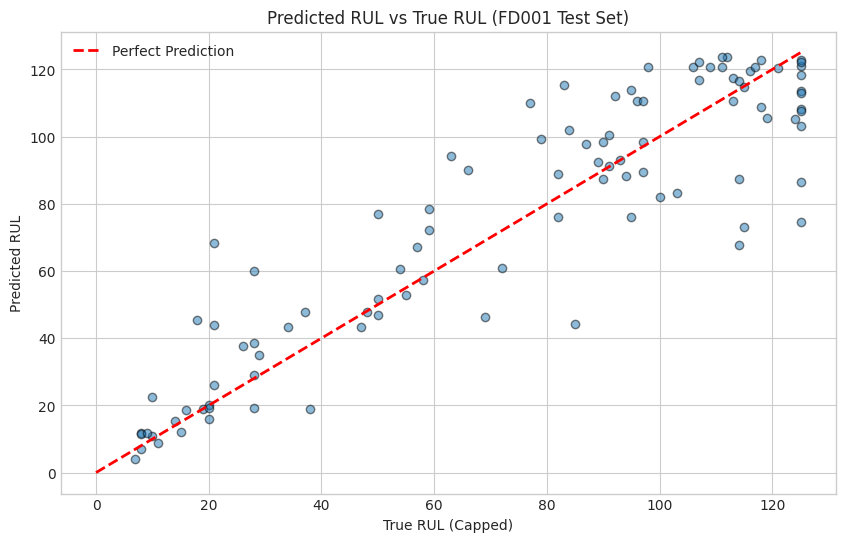

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_final_true_capped, test_predictions, alpha=0.5, edgecolors='k')
plt.plot([0, RUL_CAP], [0, RUL_CAP], 'r--', lw=2, label='Perfect Prediction') # Diagonal line
plt.xlabel("True RUL (Capped)")
plt.ylabel("Predicted RUL")
plt.title("Predicted RUL vs True RUL (FD001 Test Set)")
plt.legend()
plt.grid(True)
plt.show()

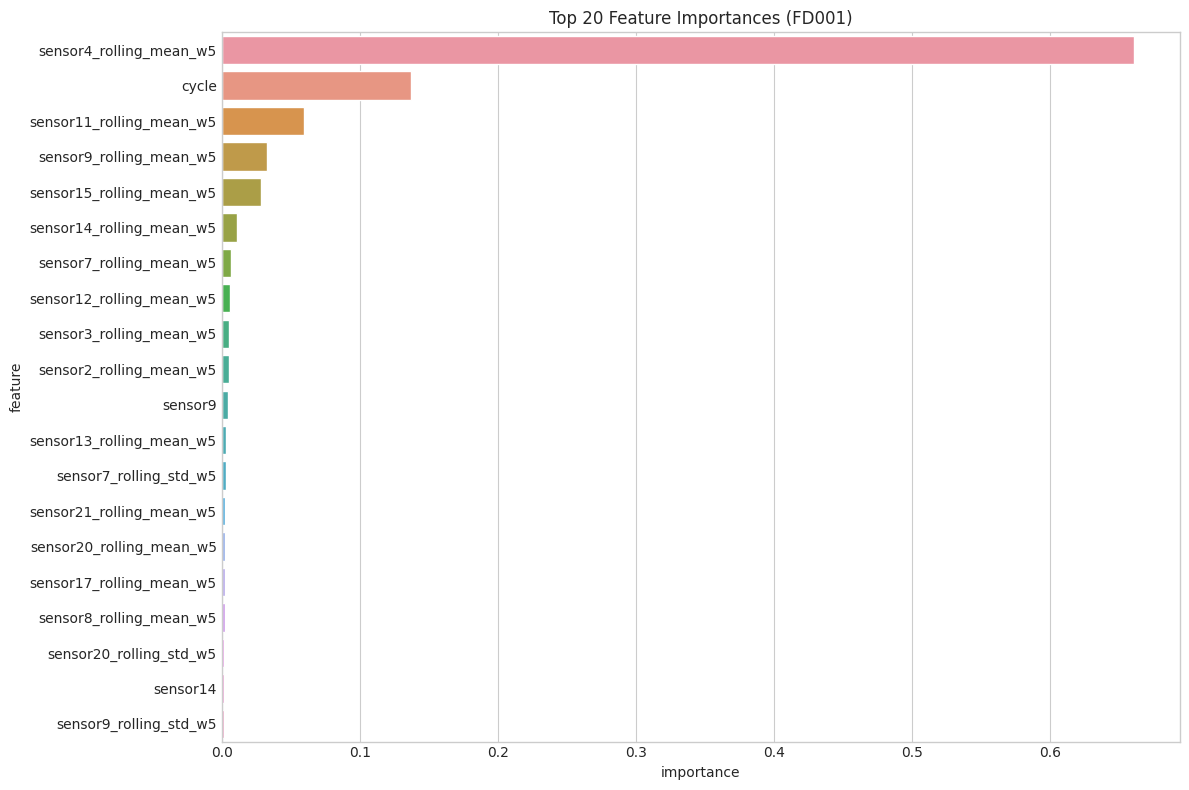

In [26]:
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    feature_names = X_train_full.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20)) # Top 20 features
    plt.title('Top 20 Feature Importances (FD001)')
    plt.tight_layout()
    plt.show()